# Problem statement
In this competitive world where IT operations are happening round the clock 24 hours, every organization yearns for quickly resolving encountered incidents to have no or minimal business impact.<br>
IT leverages incident management process to achieve this objective which after analyzing the type of the incident assign it to the respective groups to resolve the incident.<br>
In this Capstone project, the goal is to build a classifier that can classify the tickets by analyzing text. 


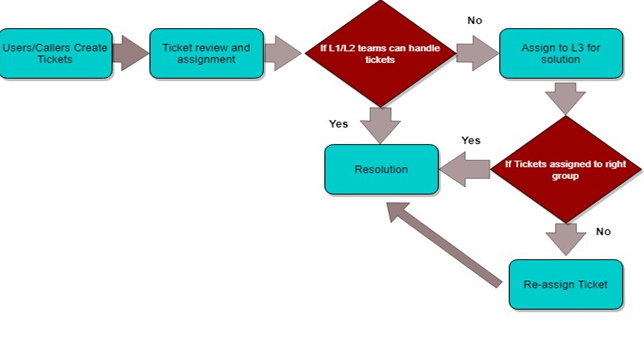

## Approach

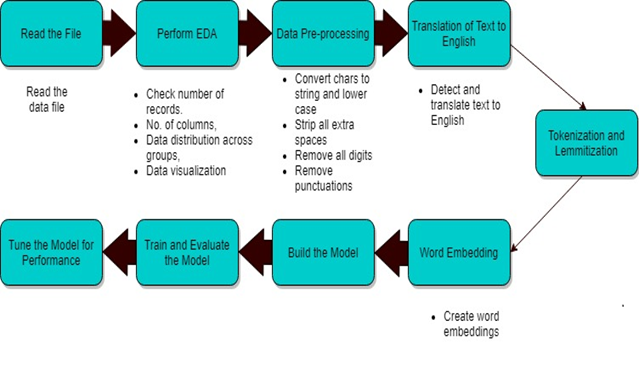

Details about the data and dataset files are given in below link,<br> 
https://drive.google.com/file/d/1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ


# Installing Prerequisite Libraries

In [1]:
!pip install langdetect
!pip install googletrans

# Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import preprocessing 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import accuracy_score, classification_report, confusion_matrix, homogeneity_score, silhouette_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn import model_selection, svm

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPool1D, SpatialDropout1D, GRU
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from collections import OrderedDict, Counter

import re

import string
from string import punctuation as punc

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.util import ngrams

from wordcloud import WordCloud, STOPWORDS 

from textblob import TextBlob
from tqdm import tqdm

from spacy.lang.en import English

import googletrans
from googletrans import Translator

from langdetect import detect, DetectorFactory

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


# Mounting Drive and read file

In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
project_path = '/content/drive/My Drive/GL AIML/Capstone'
os.chdir(project_path)

In [0]:
df = pd.read_excel('Input Data Synthetic (created but not used in our project).xlsx')

# Data understanding

In [6]:
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


<font color='blue'>The dataset consists of four variables. The summary explanation is given as below:<br>
1)	Short Description: This is a text column. It contains generic word combinations to describe the issue that has been logged by the user. Have null values.<br>
2)	Description: This is a text column. It has the detail description of the ticket. It contains unformatted, junk, multilanguage data. Have null values<br>
3)	Caller: This is a text column. It contains the name of the caller Doesn’t have null values<br>
4)	Assignment Group: The group/ level number to which the tickets were assigned to. This is our target variable. Doesn’t have null values.
</font>


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
Short description    8492 non-null object
Description          8499 non-null object
Caller               8500 non-null object
Assignment group     8500 non-null object
dtypes: object(4)
memory usage: 265.8+ KB


<font color='blue'> Dataset has total 8500 rows and 4 variables/columns. <br> 
1 Target variable - Assignment Group<br>
3 independent variables - Short description, Description, Caller<br>
All Variables are of String type.<br><br>
Column Description has 1 Null value <br>
Short Description has 8 Null values. <br>
Caller and Assignment group doesn't have any NULL values
Let's check which all index in the dataset has null values</font>

In [8]:
# Find index of NaN values
SD_nan_index = df.loc[pd.isna(df["Short description"]), :].index
Desc_nan_index = df.loc[pd.isna(df['Description']),:].index
print('Short description null at index ', SD_nan_index)
print('Short description null at index ', Desc_nan_index)

Short description null at index  Int64Index([2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341], dtype='int64')
Short description null at index  Int64Index([4395], dtype='int64')


In [0]:
#Converting all rows to String 
df['Short description']=df['Short description'].apply(str)
df['Description']=df['Description'].apply(str)
df['Caller']=df['Caller'].apply(str)

# EDA - Let's Visualize the Data distributrion

## Let's look at the distribution of our dataset based on Individual features

### Dataset Distribution by "Assignment Group"

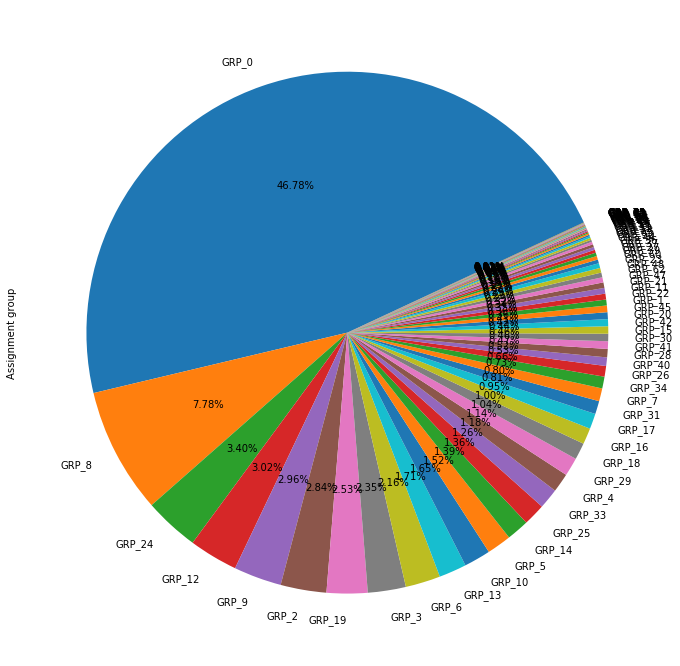

In [10]:
plt.figure(figsize=(20,12))
df["Assignment group"].value_counts().plot.pie(autopct='%1.2f%%', fontsize=10, startangle=25)

<font color='blue'> The above chart shows that the dataset is highly imbalanced based on 'Assignment Group' and it would have large impact on our Classification Model Accuracy.<br>
The dataset consists of 74 unique groups with GRP_0 holding the maximum distribution of around 47%.<br> Other major groups are GRP_8 and GRP_24 holding around 7.8% and 3.4% There are more than 35 groups which holds less then 2% of the total distribution.<br>
In later stage, we would see how can we handle the Dataset Imbalancing Problem.<br>
Let's pull the same distribution in bar chart below.</Font>

Text(0, 0.5, 'Assignment Groups')

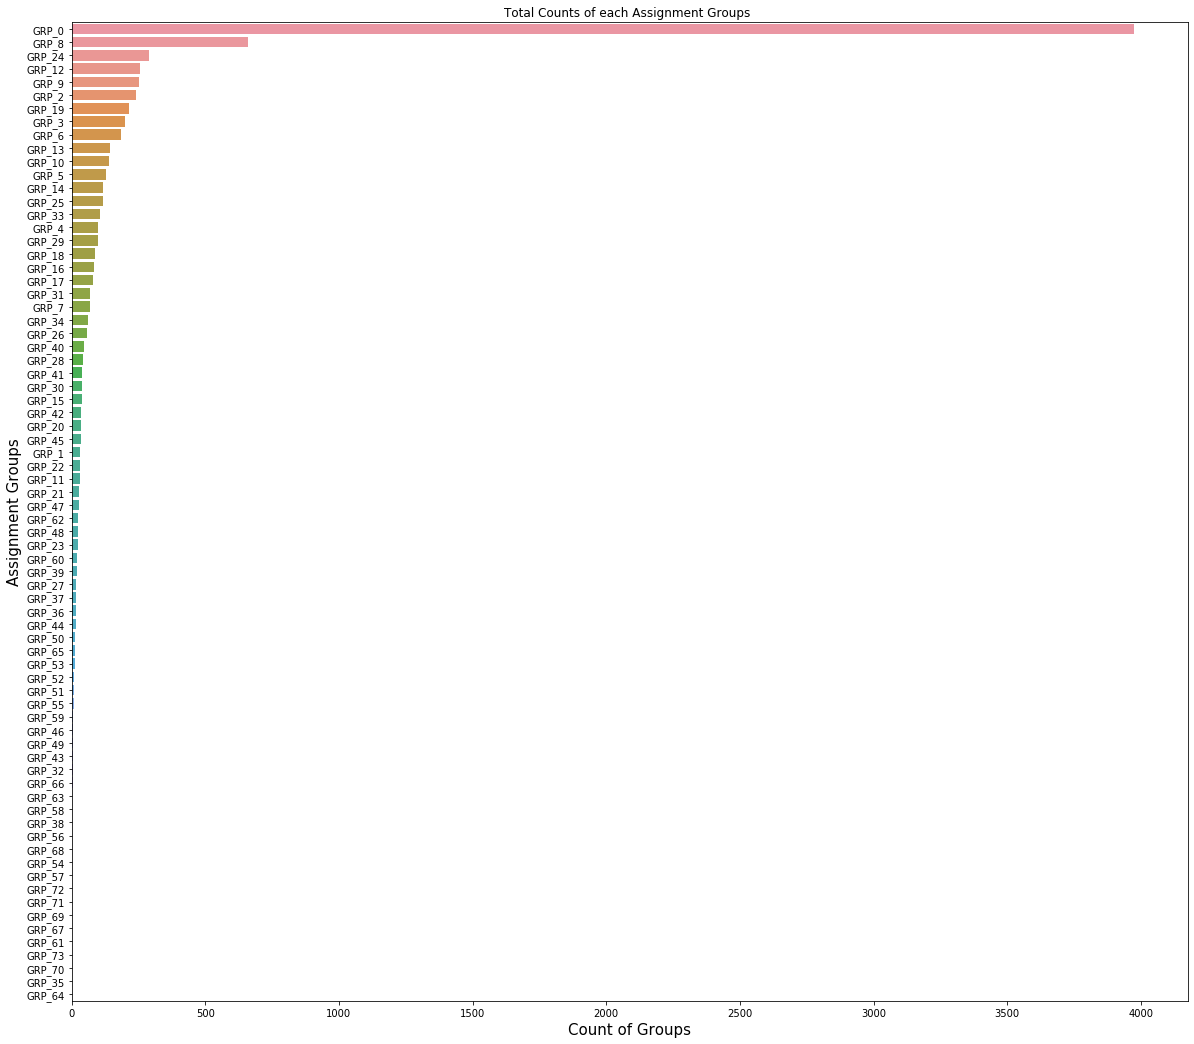

In [11]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,18))


x = df['Assignment group'].value_counts()
sns.barplot(x, x.index, ax=ax1)
plt.title('Total Counts of each Assignment Groups ')
plt.gca().set_xlabel('Count of Groups',fontsize=15)
plt.gca().set_ylabel('Assignment Groups',fontsize=15)

### Dataset Distribution by "Caller"

Text(0, 0.5, 'Callers')

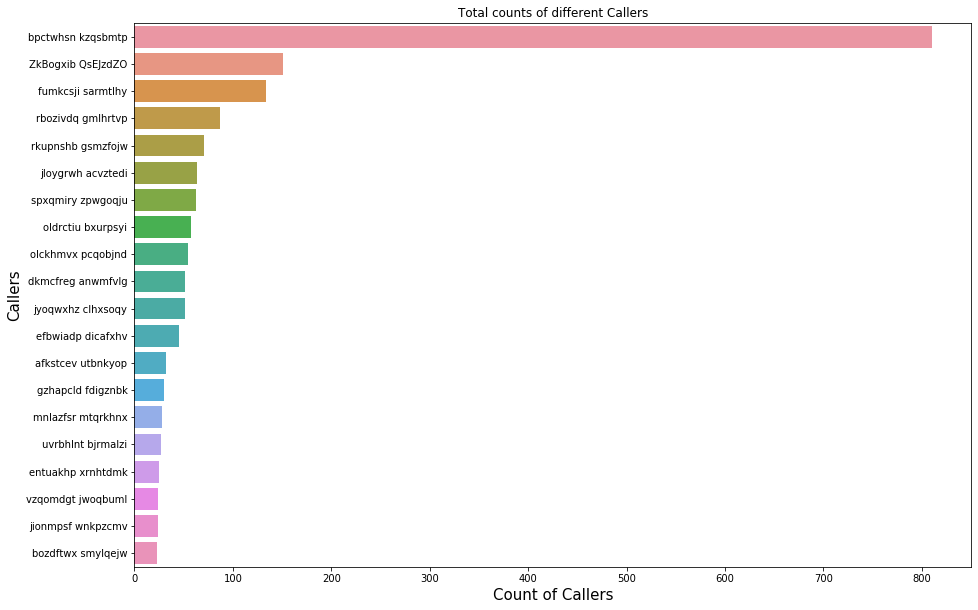

In [12]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,10))

x = df.groupby(['Caller']).size().sort_values(ascending=False).head(20)
sns.barplot(x, x.index, ax=ax1)
plt.title('Total counts of different Callers')
plt.gca().set_xlabel('Count of Callers',fontsize=15)
plt.gca().set_ylabel('Callers',fontsize=15)

<font color='blue'> "<b> bpctwhsn kzqsbmtp</b> " is the end user who has reported maximum number of tickets. So we assume, it has relationship towards prediction of Assignment group classification.<br><br>
Let's see which group most of his ticket is assigned to<font>

In [13]:
df[df['Caller']=='bpctwhsn kzqsbmtp']['Assignment group'].value_counts()

GRP_8     362
GRP_9     153
GRP_5      96
GRP_6      89
GRP_10     60
GRP_60     16
GRP_12      8
GRP_45      7
GRP_1       6
GRP_13      4
GRP_18      3
GRP_47      2
GRP_29      1
GRP_57      1
GRP_44      1
GRP_14      1
Name: Assignment group, dtype: int64

<font color='blue'> let's see what all type of issues group 8 and group 9 are resolving<font>

In [14]:
#Group by ShortDescription and Group
dfSDG = df.groupby(['Short description','Assignment group']).size().sort_values(ascending=False).reset_index()

dfSDG[dfSDG['Assignment group']=='GRP_8']['Short description'].head(8)

45     job Job_3028 failed in job_scheduler at: 08/24...
115                abended job in job_scheduler: Job_593
138    job Job_549 failed in job_scheduler at: 10/07/...
157    abended job in job_scheduler: bkbackup_tool_re...
160    abended job in job_scheduler: bk_hana_SID_62_e...
161    abended job in job_scheduler: bk_hana_SID_62_e...
166    job Job_749 failed in job_scheduler at: 08/27/...
167    job SID_41arc2 failed in job_scheduler at: 08/...
Name: Short description, dtype: object

In [15]:
#Group by ShortDescription and Group
dfSDG = df.groupby(['Short description','Assignment group']).size().sort_values(ascending=False).reset_index()

dfSDG[dfSDG['Assignment group']=='GRP_9']['Short description'].head(8)

52     abended job in job_scheduler: Job_1148
55     abended job in job_scheduler: Job_1141
92     abended job in job_scheduler: Job_1320
104    abended job in job_scheduler: Job_1142
113    abended job in job_scheduler: Job_2114
207    abended job in job_scheduler: Job_1305
243               update of ae to bw and hana
519                           issue with bobj
Name: Short description, dtype: object

<font color='blue'>We could see maximum incidents raised by “bpctwhsn kzqsbmtp” user and most of the issue are Job Failure related.<br> We assume the person may be from Operations team raising incidents for L2/L3 team.</font>

### Dataset Distribution by "Short Description"

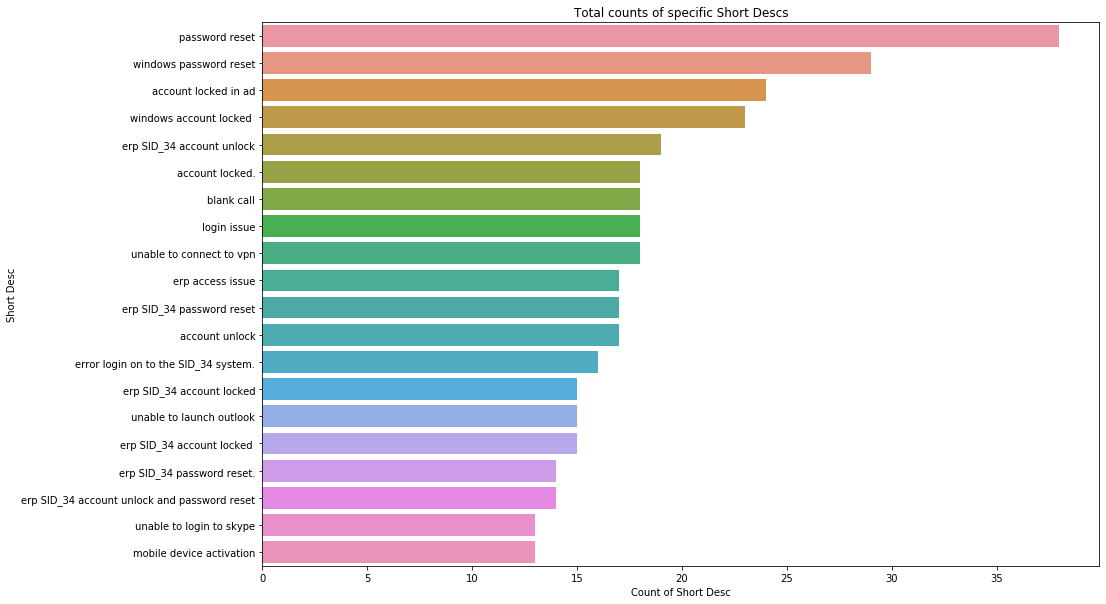

In [16]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,10))

x = df['Short description'].value_counts()[:20]
sns.barplot(x, x.index, ax=ax1)
plt.title('Total counts of specific Short Descs')
plt.gca().set_xlabel('Count of Short Desc')
plt.gca().set_ylabel('Short Desc')

plt.show()

<font color='blue'> Password reset is the type of issue, which is reported most of the time.</font>

# Let's do some feature engineering, EDA and preprocessing of data

In [0]:
df_en = df.copy()

In [18]:
df_en.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [0]:
#Converting all rows to String 
df_en['Short description']=df_en['Short description'].apply(str)
df_en['Description']=df_en['Description'].apply(str)
df_en['Caller']=df_en['Caller'].apply(str)

## Removing Caller Name from Description Feature

In [0]:
caller_list = df_en["Caller"].str.split(" ", n = 1, expand = True)

caller_fname = caller_list[0]
caller_lname = caller_list[1]

caller_fname_list = caller_fname.to_list()
caller_lname_list = caller_lname.to_list()

df_en.Description = df_en.Description.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_fname_list]))
df_en.Description = df_en.Description.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_lname_list]))

In [0]:
#Let's combine all 3 independent attribute to 1
df_en['Complete_Description'] = df_en['Short description'].str.cat(df_en['Description'],sep=" ")
#remove unnecessary spaces
df_en.Complete_Description = df_en.Complete_Description.apply(lambda x: x.strip())

In [0]:
#Remove non consecutive duplicates
df_en['Complete_Description'] = (df_en['Complete_Description'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))

In [23]:
df_en.head(2)

,Short description,Description,Caller,Assignment group,Complete_Description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue -verified user details.(employee# ...
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com hel...,hmjdrvpb komuaywn,GRP_0,outlook received from: hmjdrvpb.komuaywn@gmail...


## As all 3 independent attributes are merged into 1 column, let's remove those columns from dataframe

In [24]:
#As all 3 independent attributes are merged into 1 column, let's remove those columns from dataframe
df_en.drop(['Short description','Description','Caller'], axis=1, inplace=True)
df_en.head()

,Assignment group,Complete_Description
0,GRP_0,login issue -verified user details.(employee# ...
1,GRP_0,outlook received from: hmjdrvpb.komuaywn@gmail...
2,GRP_0,cant log in to vpn received from: eylqgodm.ybq...
3,GRP_0,unable to access hr_tool page
4,GRP_0,skype error


## We will extract some basic text features such as: <br>
    Number of words<br>
    Number of characters<br>
    Number of stopwords<br>
    Number of special characters<br>
    Number of numerics<br>
    Number of uppercase words<br>
    sentiment analysis<br>
    Non English Descriptions
    and so on...


In [25]:
nltk.download('stopwords')
stop = stopwords.words('english')

stop_words = []
stop_words += ["sr", "psa", "perpsr", "psa", "good", "evening", "will", "night", "afternoon","png", "mailto" "ca","nt","at" "i", "vip", "llv", "xyz", "cid", "image", "gmail","co", "in", "com", "ticket", "company", "received", "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "nobody", "non", "none", "nonetheless", "noone", "normally", "nos", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### WordCloud with Stopwords

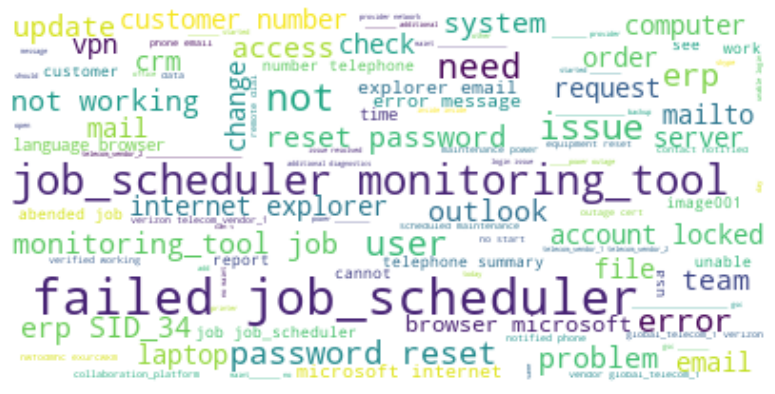

In [26]:
#Word Cloud
text = " ".join(review for review in df_en['Complete_Description'])
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Basic text Analysis

In [0]:
#df_en.Description=='nan'
def missing_val(text):
  if text=='nan':
    output='True'
  else:
    output='False'
  return output

In [0]:
def get_sentiment(text):
  sentiment = TextBlob(text).sentiment
  return sentiment[0]

In [0]:
translator = Translator()
languages = googletrans.LANGUAGES

In [0]:
DetectorFactory.seed = 0

In [0]:
def count_regexp_occ(regexp='', text=None):
    return len(re.findall(regexp, text))   

In [0]:
def txtAnalysis(data, column):
  data['word_count'] = data[column].apply(lambda x : len(x.split(" ")))
  data['char_count'] = data[column].str.len()
  data['word_density'] = data['word_count'] / (data['char_count'] + 1)
  data['punc_count'] = data[column].apply(lambda x : len([a for a in x if a in punc]))
  data['stopwords'] = data[column].apply(lambda x: len([x for x in str(x).split() if x in stop]))
  data['numerics'] = data[column].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
  data['upper'] = data[column].apply(lambda x: len([x for x in x.split() if x.isupper()]))
  data['sentiment'] = data[column].apply(lambda x : TextBlob(x).sentiment[0])
  data['is_null'] = data[column].apply(lambda x : missing_val(x))
  #data['is_english'] = data[column].apply(lambda x : True if isEnglish(x) else False)
  data['Language'] = data[column].apply(lambda x: detect(x))
  data['Language'] = data['Language'].apply(lambda x: languages[x].upper())
  data['num_symbols'] = data[column].apply(lambda x: sum(x.count(w) for w in '*#&$%?!'))
  data['num_unique_words'] = data[column].apply(lambda x: len(set(w for w in x.split())))
  data['num_smilies'] = data[column].apply(lambda x: sum(x.count(w) for w in (':-)', ':)', ';-)', ';)')))
  # Count number of \n
  data['num_slash_n'] = data[column].apply(lambda x: count_regexp_occ(r"\n", x))
  # Check for time stamp
  data['has_timestamp'] = data[column].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
  # Check for http links
  data['has_http'] = data[column].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
  return data.head(5)

In [33]:
df_eda = df_en.copy()
txtAnalysis(df_eda, 'Complete_Description')

,Assignment group,Complete_Description,word_count,char_count,word_density,punc_count,stopwords,numerics,upper,sentiment,is_null,Language,num_symbols,num_unique_words,num_smilies,num_slash_n,has_timestamp,has_http
0,GRP_0,login issue -verified user details.(employee# ...,28,183,0.152174,14,7,0,0,0.45,False,ENGLISH,2,28,0,0,0,0
1,GRP_0,outlook received from: hmjdrvpb.komuaywn@gmail...,24,177,0.134831,8,7,0,0,0.60,False,ENGLISH,1,24,0,0,0,0
2,GRP_0,cant log in to vpn received from: eylqgodm.ybq...,13,81,0.158537,4,4,0,0,1.00,False,ENGLISH,0,13,0,0,0,0
3,GRP_0,unable to access hr_tool page,5,29,0.166667,1,1,0,0,-0.50,False,ENGLISH,0,5,0,0,0,0
4,GRP_0,skype error,2,11,0.166667,0,0,0,0,0.00,False,NORWEGIAN,0,2,0,0,0,0


### English Vs Non English Description text Distribution

In [34]:
english_tickets = len(df_eda[df_eda['Language'] == 'ENGLISH'])
non_english_tickets = len(df_eda[df_eda['Language'] != 'ENGLISH'])
languages = pd.DataFrame(columns=['Language','Percentage'])
languages = languages.append({'Language':'English', 'Percentage':(english_tickets/8500)*100}, ignore_index=True)
languages = languages.append({'Language':'Non-English', 'Percentage':(non_english_tickets/8500)*100}, ignore_index=True)
languages

,Language,Percentage
0,English,82.764706
1,Non-English,17.235294


<font color='blue'> In our dataset, we have 17% of Non-English texts, As our dataset has only 8500 of data points, so if we ignore 17% of non-english data points, then we may not build a good model. <br>
So, we will handle the non-english datapoints</font>

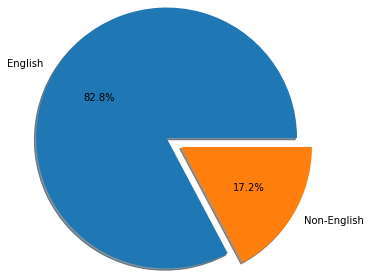

In [35]:
# Pie chart for English Vs Non-English languages
plt.figure(figsize=(4,4))
plt.pie(data=languages, x = 'Percentage', labels='Language', radius=1.5, shadow=True, autopct='%1.1f%%', explode=(0,0.2))
plt.savefig("LanguagesDist.png")

In [36]:
df_eda.groupby('Language')['Language'].count().sort_values(ascending=False)

Language
ENGLISH       7035
GERMAN         381
AFRIKAANS      255
FRENCH         146
ITALIAN        125
NORWEGIAN       91
CATALAN         80
DANISH          77
SWEDISH         76
DUTCH           58
SPANISH         38
POLISH          31
PORTUGUESE      25
FILIPINO        12
WELSH           12
ROMANIAN        11
ALBANIAN        10
SLOVENIAN        7
FINNISH          5
ESTONIAN         5
CROATIAN         5
INDONESIAN       5
TURKISH          4
LITHUANIAN       2
CZECH            2
LATVIAN          1
SLOVAK           1
Name: Language, dtype: int64

<font color='blue'> we could see our dataset has quite lots of different languages</font>

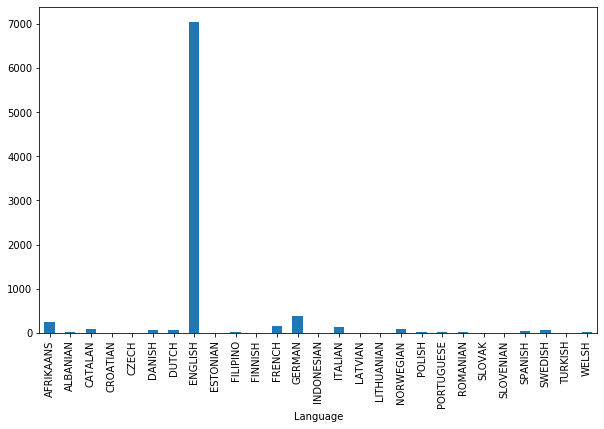

In [37]:
plt.figure(figsize=(10,6))
df_eda.groupby('Language')['Language'].count().plot.bar()

In [38]:
df_eda.describe()

,word_count,char_count,word_density,punc_count,stopwords,numerics,upper,sentiment,num_symbols,num_unique_words,num_smilies,num_slash_n,has_timestamp,has_http
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.0,8500.000000,8500.0
mean,23.176353,173.733176,0.139796,14.133294,5.179882,0.559882,0.099529,-0.043817,0.420118,23.176353,0.001529,0.0,5.031176,0.0
std,38.950384,335.434937,0.032013,50.896100,6.583806,6.751471,0.451924,0.278579,2.692823,38.950384,0.039080,0.0,31.995243,0.0
min,1.000000,1.000000,0.013514,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0
25%,6.000000,44.000000,0.117021,1.000000,1.000000,0.000000,0.000000,-0.133333,0.000000,6.000000,0.000000,0.0,0.000000,0.0
50%,12.000000,103.000000,0.141026,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.0,1.000000,0.0
75%,28.000000,198.000000,0.160654,11.000000,7.000000,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.0,6.000000,0.0
max,981.000000,8753.000000,0.500000,2296.000000,59.000000,271.000000,7.000000,1.000000,156.000000,981.000000,1.000000,0.0,1016.000000,0.0


<font color='blue'>
We draw below key insights:<br>
1)	There are around 25 words present in each column on an average with character count reaching to 192. <br>
2)	On an average 5 stop words are present in each entry along with 15 punctuations. <br>
3)	There are numerical values present in the dataset with a mean of 0.5. <br>
4)	Upper case and alphanumeric characters are present.<br>
5)	Dataset doesn't contains URL links (http) but has some timestamp values. </font>


In [39]:
df_eda.sort_values(by='word_count', ascending=False).head(5)

,Assignment group,Complete_Description,word_count,char_count,word_density,punc_count,stopwords,numerics,upper,sentiment,is_null,Language,num_symbols,num_unique_words,num_smilies,num_slash_n,has_timestamp,has_http
4089,GRP_2,security incidents - ( sw #in33895560 ) : mage...,981,8753,0.112063,572,46,271,1,-0.004900,False,ENGLISH,28,981,0,0,941,0
4087,GRP_39,security incidents - ( sw #in33895560 ) : mage...,980,8749,0.112000,571,46,271,1,-0.004900,False,ENGLISH,28,980,0,0,941,0
5433,GRP_2,security incidents - ( #in33765965 ) : possibl...,960,8009,0.119850,2296,5,218,2,-0.285511,False,CATALAN,80,960,0,0,1016,0
7997,GRP_2,security incidents - ( sw #in33544563 ) : poss...,838,7016,0.119424,720,54,119,2,-0.054466,False,ENGLISH,27,838,0,0,596,0
8002,GRP_62,security incidents - ( sw #in33544563 ) : poss...,838,7016,0.119424,720,54,119,2,-0.054466,False,ENGLISH,27,838,0,0,596,0


In [40]:
print("Maximum number of words used in the description: ",df_eda.word_count.max())

Maximum number of words used in the description:  981


In [41]:
print("Maximun number of characters used in the description: ",df_eda.char_count.max())

Maximun number of characters used in the description:  8753


In [42]:
print("Maximun number of punctuations used in the description: ",df_eda.punc_count.max())

Maximun number of punctuations used in the description:  2296


In [43]:
print("Maximun number of stopwords used in the description: ",df_eda.stopwords.max())

Maximun number of stopwords used in the description:  59


In [44]:
print("Maximun number of numerics/digits used in the description: ",df_eda.numerics.max())

Maximun number of numerics/digits used in the description:  271


## Let's visualize the features that we extracted above

### Word Density Distribution

Text(0.5, 1.0, 'Histogram of Word Density')

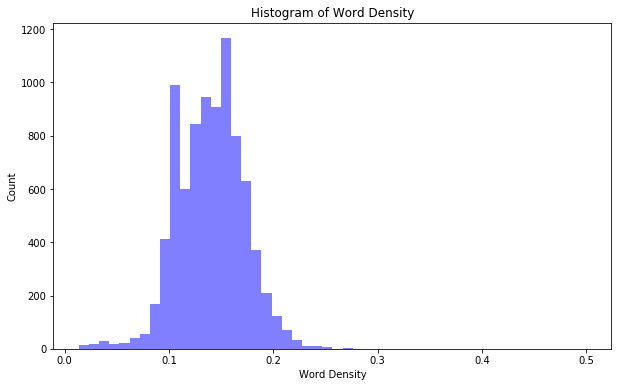

In [45]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.word_density, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Density')
plt.ylabel('Count')
plt.title('Histogram of Word Density')

### Word Count Distribution

Text(0.5, 1.0, 'Histogram of Word Count')

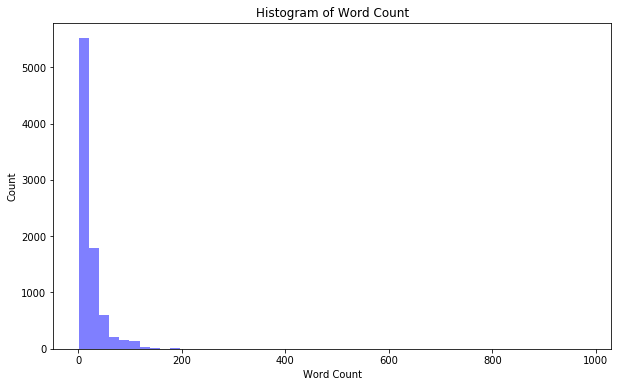

In [46]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.word_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Histogram of Word Count')

### Punctuation count Distribution

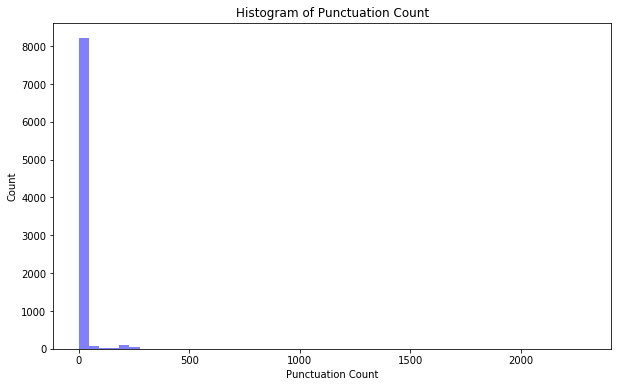

In [47]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.punc_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Punctuation Count')
plt.ylabel('Count')
plt.title('Histogram of Punctuation Count')
plt.show();

### Stopwords count Distribution

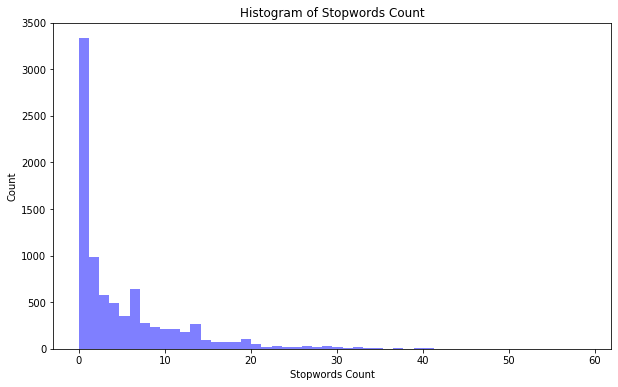

In [48]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.stopwords, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Stopwords Count')
plt.ylabel('Count')
plt.title('Histogram of Stopwords Count')
plt.show();

### Word count and stopwords Distribution

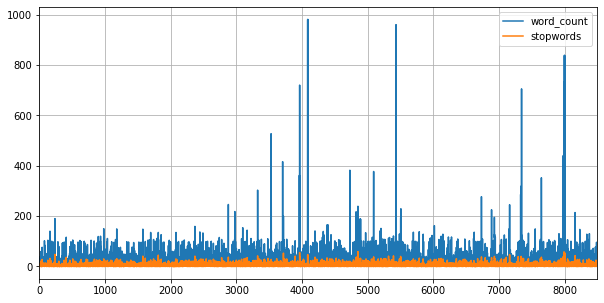

In [49]:
df_eda[['word_count','stopwords']].plot(figsize=(10,5), grid=True)

### Word count and punctuation count Distribution

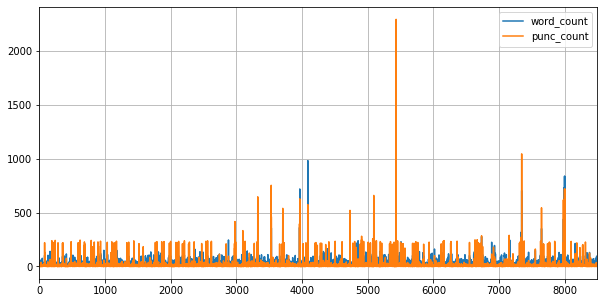

In [50]:
df_eda[['word_count','punc_count']].plot(figsize=(10,5), grid=True)

<font color='blue'> looks like data has more punctuations. We will handle the same in later stage </font>

### Numerics count distribution

Text(0.5, 1.0, 'Histogram of Numeric Count in Description')

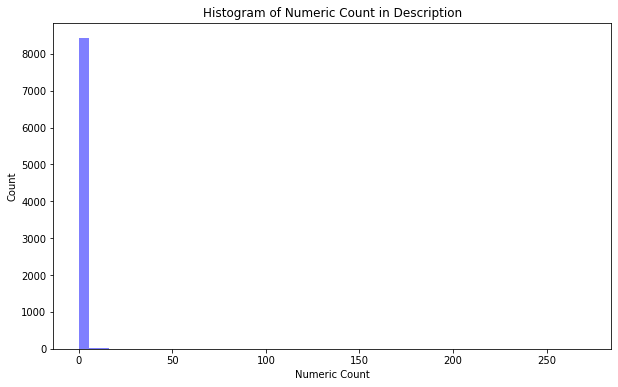

In [51]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.numerics, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Numeric Count')
plt.ylabel('Count')
plt.title('Histogram of Numeric Count in Description')

### Null values Distribution after merging short description and description columns

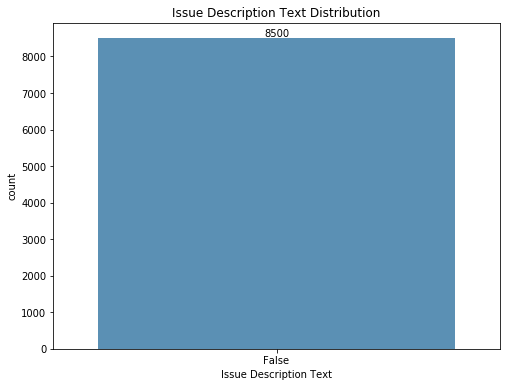

In [52]:
x=df_eda['is_null'].value_counts()
x=x.sort_index()
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Issue Description Text Distribution")
plt.ylabel('count')
plt.xlabel('Issue Description Text')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

### Sentiment Analysis Distribution

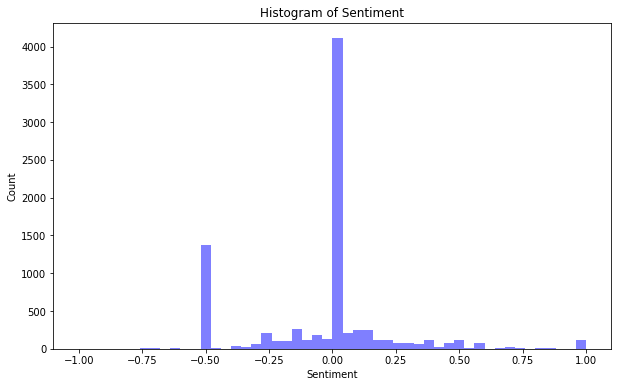

In [53]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Histogram of Sentiment')
plt.show();

#### Let's see the text based on the sentiment

##### Positive selntiment texts

In [54]:
print('3 random Description with the highest positive sentiment: \n')
print('*********************************************************')
cl = df_eda.loc[df_eda.sentiment == 1, ['Complete_Description']].sample(3).values
for c in cl:
    print(c[0])
    print('---------------------')

3 random Description with the highest positive sentiment: 

*********************************************************
password cannot changed received from: tbukjcyl.lxncwqbj@gmail.com dear all could you please help me to fix it, [cid:image001.jpg@01d1f978.729627d0] best
---------------------
email-anzeige received from: trgqbeax.hfyzudql@gmail.com [cid:image001.png@01d1f7b0.223a83e0] leider ist das feld â€žvon" abhanden gekommen â˜¹ danke + viele grÃ¼ÃŸe mit freundlichen grÃ¼ÃŸen | best
---------------------
unlock erp logon received from: jofvunqs.uwigjmzv@gmail.com hello: please help me logon. i can not the system ,input my password. best
---------------------


##### Neutral sentiment texts

In [55]:
print('3 random Description with the Neutral sentiment: \n')
print('*********************************************************')
cl = df_eda.loc[df_eda.sentiment == 0, ['Complete_Description']].sample(3).values
for c in cl:
    print(c[0])
    print('---------------------')

3 random Description with the Neutral sentiment: 

*********************************************************
password reset and access to reporting_engineering_tools
---------------------
erp SID_34 account locked.
---------------------
phishing emails uacyltoe hxgaycze query
---------------------


##### Negative sentiment texts

In [56]:
df_eda.sentiment.min()

-1.0

In [57]:
print('Description with the most negative sentiment: \n')
print('*********************************************************')
cl = df_eda.loc[df_eda.sentiment == -1.0, ['Complete_Description']].values
for c in cl:
    print(c[0])

Description with the most negative sentiment: 

*********************************************************
pls. help to run out dn under sto#5019320060,thx! received from: wktesmbp.lorjymef@gmail.com dear team, we got a stock recall notic#plant_101-101016-01 for mm#3098450 & should return 373pc materials plant_101,then i created sto#5019320060 base on this recall. dn#916955708/105pc was just against the sto, of rest 268pc ,thx lot! [cid:image001.png@01d223c2.0ac78080] b.rgds judthtihty.zhuyhts company hardpoint apac-wgq dc


### Most Common and Rare words

#### Most Common

In [58]:
Counter(" ".join(df_eda['Complete_Description']).split() ).most_common(20)

[('to', 3316),
 ('in', 2642),
 ('the', 2555),
 ('from:', 2445),
 ('received', 2329),
 ('is', 1937),
 ('not', 1688),
 ('on', 1592),
 ('and', 1545),
 ('please', 1524),
 ('for', 1482),
 ('i', 1261),
 ('a', 1164),
 ('of', 1052),
 ('it', 1017),
 ('job', 997),
 ('erp', 969),
 ('monitoring_tool@company.com', 961),
 ('password', 937),
 ('unable', 870)]

#### Rare words

In [59]:
#Least Word Freq
pd.set_option('display.max_colwidth', -1)

S = pd.Series(" ".join(df_eda['Complete_Description']).split() ).value_counts().sort_values(ascending=True)
df_least_word_freq = pd.DataFrame(S).reset_index()
df_least_word_freq.columns = ['word', 'count']
df_least_word_freq[df_least_word_freq['count'] < 5]

,word,count
0,imaginal,1
1,12:43:00,1
2,xgrhplvk.coejktzn@gmail.com,1
3,outside:192.168.0.109/135,1
4,krcscfpr061y,1
...,...,...
27874,456e,4
27875,crashed,4
27876,easy,4
27877,"ÑƒÐ²Ð°Ð¶ÐµÐ½Ð¸ÐµÐ¼,",4


### Preprocessing

In [0]:
dfTicketAssign =  df_eda.copy()

In [61]:
dfTicketAssign.head()

,Assignment group,Complete_Description,word_count,char_count,word_density,punc_count,stopwords,numerics,upper,sentiment,is_null,Language,num_symbols,num_unique_words,num_smilies,num_slash_n,has_timestamp,has_http
0,GRP_0,login issue -verified user details.(employee# & manager name) -checked the name in ad and reset password. -advised to check. -caller confirmed that he was able login. -issue resolved.,28,183,0.152174,14,7,0,0,0.45,False,ENGLISH,2,28,0,0,0,0
1,GRP_0,"outlook received from: hmjdrvpb.komuaywn@gmail.com hello team, my meetings/skype meetings etc are not appearing in calendar, can somebody please advise how to correct this? kind",24,177,0.134831,8,7,0,0,0.60,False,ENGLISH,1,24,0,0,0,0
2,GRP_0,cant log in to vpn received from: eylqgodm.ybqkwiam@gmail.com hi i cannot on best,13,81,0.158537,4,4,0,0,1.00,False,ENGLISH,0,13,0,0,0,0
3,GRP_0,unable to access hr_tool page,5,29,0.166667,1,1,0,0,-0.50,False,ENGLISH,0,5,0,0,0,0
4,GRP_0,skype error,2,11,0.166667,0,0,0,0,0.00,False,NORWEGIAN,0,2,0,0,0,0


#### Basic Preprocessing

In [0]:
regexList = ['From:(.*)\r\n',
 'IiNnCc[0-9]*',
 'ticket[_]*[\\s]*[0-9]*',
 'Sent:(.*)\r\n',
 'Received:(.*)\r\n',
 'To:(.*)\r\n',
 'CC:(.*)\r\n',
 '\\[cid:(.*)]',
 'https?:[^\\]\n\r]+',
 'Subject:',
 '[0-9][\\-0–90-9 ]+',# phones
 '[0-9]',# numbers
 '[^a-zA-z 0-9]+',# anything that is not a letter
 '[\r\n]',# single letters
 ' [a-zA-Z] ',  # two-letter words
 '  ', # double spaces
 '^[_a-z0-9-]+(\\.[_a-z0-9-]+)*@[a-z0-9-]+(\\.[a-z0-9-]+)*(\\.[a-z]{2,4})$',
 '[\\w\\d\\-\\_\\.]+ @ [\\w\\d\\-\\_\\.]+',
 'Subject:',
 '[^a-zA-Z]',
 '\\S+@\\S+',# emails 
 "\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b" #IP Address
 ]

In [0]:
#Remove punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
          text = text.replace(punctuation, ' ')
    return text

In [0]:
def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

In [0]:
#Translate tickets to English
def fn_translate(desc, lang):
  try:
    if lang == 'ENGLISH':
        return desc
    else:
        return translator.translate(desc).text
  except:
    return desc

In [0]:
def textPreprocessing(data,column):
  print("updating all cases to lower cases:")
  data[column] = data[column].apply(lambda x: " ".join(x.lower() for x in x.split()))
  print("Translating Non English to English:")
  data['EnglishDescription'] = data.apply(lambda x: fn_translate(x[column], x['Language']), axis=1)
  print("removing data using regular expression List:")
  for regex in regexList:
            data['EnglishDescription'] = removeString(data['EnglishDescription'], regex)
  print("removing stopwords:")            
  data['EnglishDescription'] = data['EnglishDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
  freq = pd.Series(' '.join(data['EnglishDescription']).split()).value_counts()[:20]
  print("removing top 20 Most common words:")
  data['EnglishDescription'] = data['EnglishDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
  rare = pd.Series(' '.join(data['EnglishDescription']).split()).value_counts()[-20:]
  print("removing top 20 rare words ata using regular expression List:")
  data['EnglishDescription'] = data['EnglishDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))
  print("removing punctuations:")
  data['EnglishDescription'] = data['EnglishDescription'].apply(remove_punctuations)
  return data.head(5)


In [67]:
dfTicketAssign.head()

,Assignment group,Complete_Description,word_count,char_count,word_density,punc_count,stopwords,numerics,upper,sentiment,is_null,Language,num_symbols,num_unique_words,num_smilies,num_slash_n,has_timestamp,has_http
0,GRP_0,login issue -verified user details.(employee# & manager name) -checked the name in ad and reset password. -advised to check. -caller confirmed that he was able login. -issue resolved.,28,183,0.152174,14,7,0,0,0.45,False,ENGLISH,2,28,0,0,0,0
1,GRP_0,"outlook received from: hmjdrvpb.komuaywn@gmail.com hello team, my meetings/skype meetings etc are not appearing in calendar, can somebody please advise how to correct this? kind",24,177,0.134831,8,7,0,0,0.60,False,ENGLISH,1,24,0,0,0,0
2,GRP_0,cant log in to vpn received from: eylqgodm.ybqkwiam@gmail.com hi i cannot on best,13,81,0.158537,4,4,0,0,1.00,False,ENGLISH,0,13,0,0,0,0
3,GRP_0,unable to access hr_tool page,5,29,0.166667,1,1,0,0,-0.50,False,ENGLISH,0,5,0,0,0,0
4,GRP_0,skype error,2,11,0.166667,0,0,0,0,0.00,False,NORWEGIAN,0,2,0,0,0,0


In [68]:
textPreprocessing(dfTicketAssign,'Complete_Description')

updating all cases to lower cases:
Translating Non English to English:
removing data using regular expression List:
removing stopwords:
removing top 20 Most common words:
removing top 20 rare words ata using regular expression List:
removing punctuations:


,Assignment group,Complete_Description,word_count,char_count,word_density,punc_count,stopwords,numerics,upper,sentiment,is_null,Language,num_symbols,num_unique_words,num_smilies,num_slash_n,has_timestamp,has_http,EnglishDescription
0,GRP_0,login issue -verified user details.(employee# & manager name) -checked the name in ad and reset password. -advised to check. -caller confirmed that he was able login. -issue resolved.,28,183,0.152174,14,7,0,0,0.45,False,ENGLISH,2,28,0,0,0,0,login verified details employee manager checked advised check caller confirmed login resolved
1,GRP_0,"outlook received from: hmjdrvpb.komuaywn@gmail.com hello team, my meetings/skype meetings etc are not appearing in calendar, can somebody please advise how to correct this? kind",24,177,0.134831,8,7,0,0,0.60,False,ENGLISH,1,24,0,0,0,0,outlook hmjdrvpb komuaywn team meetings skype meetings appearing calendar somebody advise correct kind
2,GRP_0,cant log in to vpn received from: eylqgodm.ybqkwiam@gmail.com hi i cannot on best,13,81,0.158537,4,4,0,0,1.00,False,ENGLISH,0,13,0,0,0,0,cant log vpn eylqgodm ybqkwiam cannot
3,GRP_0,unable to access hr_tool page,5,29,0.166667,1,1,0,0,-0.50,False,ENGLISH,0,5,0,0,0,0,hr
4,GRP_0,skype error,2,11,0.166667,0,0,0,0,0.00,False,NORWEGIAN,0,2,0,0,0,0,skype


### Most Common words after preprocessing

In [69]:
counter = Counter(" ".join(dfTicketAssign['EnglishDescription']).split() ).most_common(20)
counter

[('system', 606),
 ('network', 591),
 ('outlook', 549),
 ('need', 546),
 ('vendor', 525),
 ('login', 523),
 ('power', 494),
 ('telecom', 481),
 ('message', 439),
 ('see', 412),
 ('phone', 404),
 ('outage', 401),
 ('team', 383),
 ('locked', 370),
 ('usa', 355),
 ('vpn', 341),
 ('update', 339),
 ('server', 337),
 ('number', 336),
 ('contact', 334)]

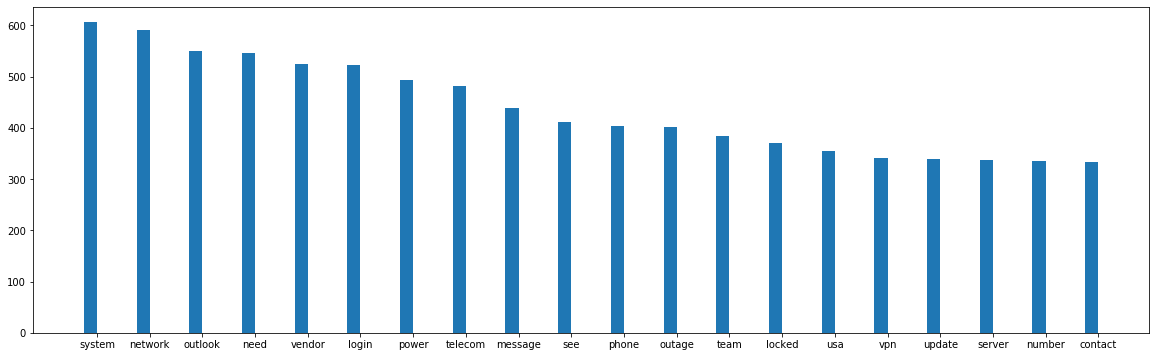

In [70]:
labels, values = zip(*Counter(" ".join(dfTicketAssign['EnglishDescription']).split() ).most_common(20))
plt.figure(figsize=(20,6))

indexes = np.arange(len(labels))
width = 0.25

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [71]:
pd.set_option('display.max_colwidth', -1)

S = pd.Series(" ".join(dfTicketAssign['EnglishDescription']).split() ).value_counts().sort_values(ascending=True)
df_least_word_freq = pd.DataFrame(S).reset_index()
df_least_word_freq.columns = ['word', 'count']
df_least_word_freq[df_least_word_freq['count'] < 5]

,word,count
0,uncaught,1
1,vbmzgsdk,1
2,gerberghty,1
3,stamped,1
4,awnftgev,1
...,...,...
11353,outputs,4
11354,soll,4
11355,komuaywn,4
11356,cyxieuwk,4


#### Tokenization and Lemmatization

<font color='blue'> We performed basic cleaning of our dataset.<br>
Let's look into tokenization, N-grams and visualize how our dataset looks</font>

In [0]:
# Word tokenization
nlp = English()

In [0]:
def tokenizeText(text):
  #  "nlp" Object is used to create documents with linguistic annotations.
  my_doc = nlp(text)
  # Create list of word tokens
  token_list = []
  for token in my_doc:
    token_list.append(token.text)
  return token_list

In [74]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
dfTicketAssign['Tokens'] = dfTicketAssign['EnglishDescription'].apply(lambda x: tokenizeText(x))

In [0]:
#Cleaning stop words after tokenization
cleanTokens = []
for col_desc in range(len(dfTicketAssign.Tokens)):
  str_token = dfTicketAssign.Tokens[col_desc]
  cleanTokens.append([w for w in str_token if w not in stop_words] )

dfTicketAssign['Tokens'] = cleanTokens

In [0]:
# Python code to remove duplicate elements after tokenization
def RemovDupWordTokens(dupToken): 
    finalTokenlist = [] 
    for num in dupToken: 
        if num not in finalTokenlist: 
            finalTokenlist.append(num) 
    return finalTokenlist 

In [0]:
def lemmatizeText(text):
  text = ' '.join(map(str, text)) 
  # Implementing lemmatization
  lem = nlp(text)
  lemma_list = []
  # finding lemma for each word
  for word in lem:
    lemma_list.append(word.lemma_)
  return lemma_list
  #return list(set(lemma_list))

In [0]:
dfTicketAssign['LemmaWords'] = dfTicketAssign['Tokens'].apply(lambda x: lemmatizeText(x))

#### Word Cloud after Lemmatization

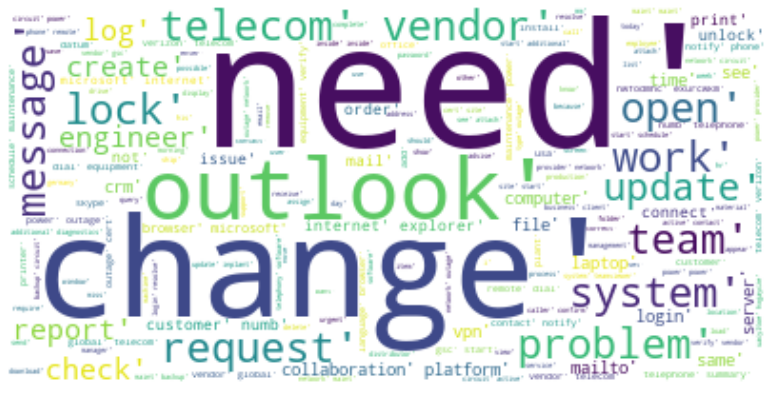

In [80]:
#Word Cloud
text = ' '.join(map(str, dfTicketAssign.LemmaWords))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [81]:
print('Average count of chars per Description cell is {0:.0f}.'.format(dfTicketAssign.groupby('Assignment group')['EnglishDescription'].count().mean()))

Average count of chars per Description cell is 115.


In [0]:
dfTicketAssign['LemmaWords'] = dfTicketAssign['LemmaWords'].apply(lambda x: RemovDupWordTokens(x))

#### Word Cloud after removing duplicates from Lemmatized words

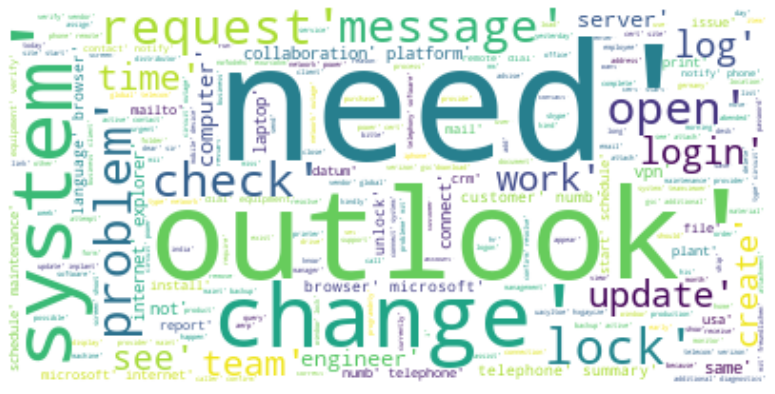

In [83]:
#Word Cloud
text = ' '.join(map(str, dfTicketAssign.LemmaWords))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### N-Grams

In [0]:
dfTicketngrams = dfTicketAssign.copy()

In [85]:
dfTicketngrams.head(5)

,Assignment group,Complete_Description,word_count,char_count,word_density,punc_count,stopwords,numerics,upper,sentiment,is_null,Language,num_symbols,num_unique_words,num_smilies,num_slash_n,has_timestamp,has_http,EnglishDescription,Tokens,LemmaWords
0,GRP_0,login issue -verified user details.(employee# & manager name) -checked the name in ad and reset password. -advised to check. -caller confirmed that he was able login. -issue resolved.,28,183,0.152174,14,7,0,0,0.45,False,ENGLISH,2,28,0,0,0,0,login verified details employee manager checked advised check caller confirmed login resolved,"[login, verified, details, employee, manager, checked, advised, check, caller, confirmed, login, resolved]","[login, verify, detail, employee, manager, check, advise, caller, confirm, resolve]"
1,GRP_0,"outlook received from: hmjdrvpb.komuaywn@gmail.com hello team, my meetings/skype meetings etc are not appearing in calendar, can somebody please advise how to correct this? kind",24,177,0.134831,8,7,0,0,0.60,False,ENGLISH,1,24,0,0,0,0,outlook hmjdrvpb komuaywn team meetings skype meetings appearing calendar somebody advise correct kind,"[outlook, hmjdrvpb, komuaywn, team, meetings, skype, meetings, appearing, calendar, somebody, advise, correct, kind]","[outlook, hmjdrvpb, komuaywn, team, meeting, skype, appear, calendar, somebody, advise, correct, kind]"
2,GRP_0,cant log in to vpn received from: eylqgodm.ybqkwiam@gmail.com hi i cannot on best,13,81,0.158537,4,4,0,0,1.00,False,ENGLISH,0,13,0,0,0,0,cant log vpn eylqgodm ybqkwiam cannot,"[log, vpn, eylqgodm, ybqkwiam, not]","[log, vpn, eylqgodm, ybqkwiam, not]"
3,GRP_0,unable to access hr_tool page,5,29,0.166667,1,1,0,0,-0.50,False,ENGLISH,0,5,0,0,0,0,hr,[hr],[hr]
4,GRP_0,skype error,2,11,0.166667,0,0,0,0,0.00,False,NORWEGIAN,0,2,0,0,0,0,skype,[skype],[skype]


In [0]:
def get_top_ticketdesc_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(words_freq)
    return words_freq[:n]

[('system', 606), ('network', 591), ('outlook', 549), ('need', 546), ('vendor', 525), ('login', 523), ('power', 494), ('telecom', 481), ('message', 439), ('see', 412), ('phone', 404), ('outage', 401), ('team', 383), ('locked', 370), ('usa', 355), ('vpn', 341), ('update', 339), ('server', 337), ('number', 336), ('contact', 334), ('customer', 332), ('check', 327), ('log', 325), ('plant', 317), ('engineering', 310), ('time', 310), ('circuit', 307), ('manager', 305), ('cannot', 301), ('windows', 301), ('request', 300), ('summary', 297), ('site', 296), ('crm', 295), ('open', 289), ('mailto', 289), ('skype', 286), ('maint', 285), ('type', 282), ('microsoft', 282), ('problem', 271), ('management', 260), ('attached', 260), ('internet', 248), ('change', 245), ('data', 243), ('connect', 233), ('order', 231), ('work', 230), ('sales', 230), ('start', 228), ('language', 225), ('platform', 224), ('global', 224), ('same', 224), ('collaboration', 223), ('printer', 221), ('software', 215), ('unlock', 2

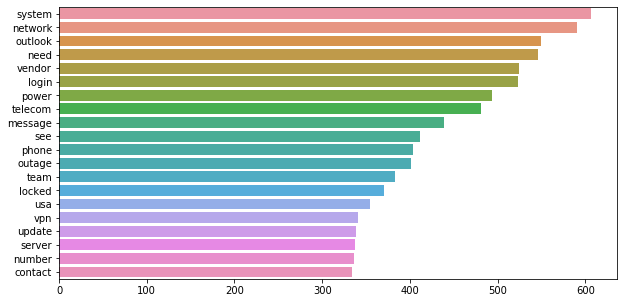

In [87]:
plt.figure(figsize=(10,5))
top_unigrams=get_top_ticketdesc_unigrams(dfTicketngrams['EnglishDescription'])[:20]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x)

In [0]:
def get_top_ticketdesc_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

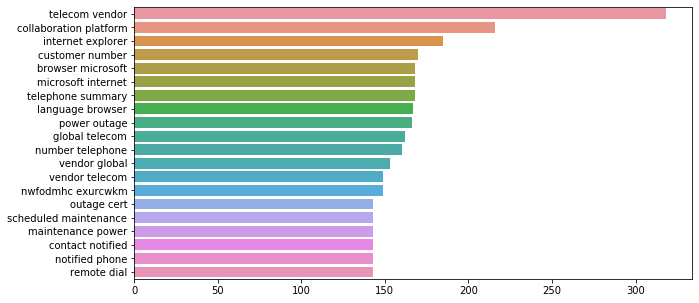

In [89]:
plt.figure(figsize=(10,5))
top_bigrams=get_top_ticketdesc_bigrams(dfTicketngrams['EnglishDescription'])[:20]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

In [0]:
def get_top_ticketdesc_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

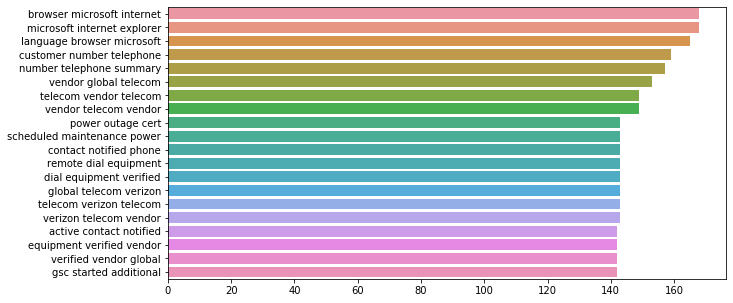

In [91]:
plt.figure(figsize=(10,5))
top_trigrams=get_top_ticketdesc_trigrams(dfTicketngrams['EnglishDescription'])[:20]
x,y=map(list,zip(*top_trigrams))
sns.barplot(x=y,y=x)

#### Create Corpus

In [0]:
def listToString(s):
  str1 = " "
  for ele in s:
    str1 = str1 + " " + ele
  return str1

In [0]:
def create_corpus(df):
    corpus=[]
    for desc in tqdm(df['LemmaString'].astype(str)):
        words=[word.lower() for word in word_tokenize(desc) if((word.isalpha()==1))] # & (word not in stop_words))]
        corpus.append(words)
    return corpus

In [94]:
dfTicketngrams['LemmaString'] = dfTicketngrams['LemmaWords'].apply(lambda x: listToString(x))

corpus=create_corpus(dfTicketngrams)

100%|██████████| 8500/8500 [00:00<00:00, 9873.53it/s]


## Model Building

### Approach 1 ( Classification Approach )
Classification of 75 groups

#### Train and test Split

In [95]:
df1= dfTicketngrams[['LemmaString','Assignment group']]
df1.head()

,LemmaString,Assignment group
0,login verify detail employee manager check advise caller confirm resolve,GRP_0
1,outlook hmjdrvpb komuaywn team meeting skype appear calendar somebody advise correct kind,GRP_0
2,log vpn eylqgodm ybqkwiam not,GRP_0
3,hr,GRP_0
4,skype,GRP_0


In [0]:
X_train = df1.loc[:6000, 'LemmaString'].values
y_train = df1.loc[:6000, 'Assignment group'].values
X_test = df1.loc[6001:, 'LemmaString'].values
y_test = df1.loc[6001:, 'Assignment group'].values

In [97]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

(6001, 9959) (2499, 9959)


#### Model

##### Naive Bayes

In [0]:
clf = MultinomialNB().fit(train_vectors, y_train)

In [99]:
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.49459783913565425


In [100]:
print(predicted[1])

GRP_0


In [101]:
cm = confusion_matrix(y_test, predicted) 
cm

array([[1131,    0,    0, ...,    0,    3,    0],
       [   4,    0,    0, ...,    0,    4,    0],
       [  26,    0,    0, ...,    0,    0,    0],
       ...,
       [   1,    0,    0, ...,    0,    0,    0],
       [ 112,    0,    0, ...,    0,   81,    0],
       [  71,    0,    0, ...,    0,    0,    0]])

##### SVM Model

In [0]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto')

In [103]:
SVM.fit(train_vectors ,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [104]:
predictions = SVM.predict(test_vectors)
print("SVM Accuracy Score -> ",accuracy_score(predictions, y_test)*100)

SVM Accuracy Score ->  59.343737494997995


In [105]:
Lcm = confusion_matrix(y_test, predictions) 
print(Lcm)

[[1096    0    0 ...    0    3    0]
 [   2    0    0 ...    0    0    0]
 [  16    0    8 ...    0    0    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  85    0    0 ...    0   97    0]
 [  64    0    0 ...    0    1    4]]


In [106]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       GRP_0       0.57      0.97      0.72      1134
       GRP_1       0.00      0.00      0.00         9
      GRP_10       0.89      0.31      0.46        26
      GRP_11       0.00      0.00      0.00        13
      GRP_12       0.62      0.39      0.48        94
      GRP_13       0.40      0.39      0.40        41
      GRP_14       0.67      0.37      0.47        38
      GRP_15       0.00      0.00      0.00        12
      GRP_16       0.00      0.00      0.00        18
      GRP_17       0.90      1.00      0.95        19
      GRP_18       0.54      0.28      0.37        25
      GRP_19       0.55      0.09      0.15        68
       GRP_2       0.58      0.44      0.50        64
      GRP_20       0.00      0.00      0.00        13
      GRP_21       0.00      0.00      0.00         8
      GRP_22       0.00      0.00      0.00        12
      GRP_23       0.50      0.29      0.36         7
      GRP_24       0.78    

##### Grid Search CV

In [107]:
params_grid = [{'kernel': ['linear','rbf'], 'C': [10.0,1.0,0.1,0.01]}]

svm_model_pc = GridSearchCV(svm.SVC(probability=True, decision_function_shape='ovr'), params_grid,cv=5,  verbose=1)

svm_model_pc.fit(train_vectors, y_train)

svm_model_pc.score

# View the accuracy score
print('Best score for training data:', svm_model_pc.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model_pc.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model_pc.best_estimator_.kernel,"\n")

final_model_pc = svm_model_pc.best_estimator_

y_pred = final_model_pc.predict(test_vectors)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 26.7min finished


Best score for training data: 0.6025661948376353 

Best C: 1.0 

Best Kernel: linear 



In [108]:
print("Training score for GridSearch SVM: %f" % final_model_pc.score(train_vectors, y_train))
print("Testing score for GridSearch SVM: %f" % final_model_pc.score(test_vectors, y_test))
print("\n")

Training score for GridSearch SVM: 0.768539
Testing score for GridSearch SVM: 0.593437




In [109]:
Lcm = confusion_matrix(y_test, y_pred) 
print(Lcm)

[[1096    0    0 ...    0    3    0]
 [   2    0    0 ...    0    0    0]
 [  16    0    8 ...    0    0    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  85    0    0 ...    0   97    0]
 [  64    0    0 ...    0    1    4]]


##### Deep Learning

In [110]:
df1.head()

,LemmaString,Assignment group
0,login verify detail employee manager check advise caller confirm resolve,GRP_0
1,outlook hmjdrvpb komuaywn team meeting skype appear calendar somebody advise correct kind,GRP_0
2,log vpn eylqgodm ybqkwiam not,GRP_0
3,hr,GRP_0
4,skype,GRP_0


In [0]:
## TOTAL NUMBER OF WORDS USED IN EACH HEADLINE
df1['nb_words'] = df1.LemmaString.apply(lambda x: len(x.split()))

## TOTAL NUMBER OF UNIQUE WORDS USED IN EACH HEADLINE
df1['nb_unique_words'] = df1.LemmaString.apply(lambda x: len(set(x.split())))

## TOTAL NUMBER OF CHARACTERS USED IN EACH HEADLINE
df1['nb_char'] = df1.LemmaString.apply(lambda x: len(x))

In [112]:
df1.LemmaString

0         login verify detail employee manager check advise caller confirm resolve                 
1         outlook hmjdrvpb komuaywn team meeting skype appear calendar somebody advise correct kind
2         log vpn eylqgodm ybqkwiam not                                                            
3         hr                                                                                       
4         skype                                                                                    
         ...                                                                                       
8495      email come mail avglmrts vhqmtiua receive advise                                         
8496      telephony software                                                                       
8497      window tifpdchb pedxruyf                                                                 
8498      machine funcionando utility finish drawer adjustment setting network                     


In [113]:
maxlen = df1['nb_words'].max()
print(maxlen)

395


In [0]:
max_features = 10000
embedding_size = 50

In [0]:
tokenizer_obj=Tokenizer(num_words=max_features)
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

In [0]:
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer_obj.fit_on_texts(corpus)

In [117]:
X = tokenizer_obj.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxlen)

df1['Assignment group'].astype(str)
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in column 'species'. 
y = df1['Assignment group']= label_encoder.fit_transform(df1['Assignment group']) 
y = to_categorical(y, num_classes= 74)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

Number of Samples: 8500
Number of Labels:  8500


###### Get the Vocabulary size

In [118]:
word_index = tokenizer_obj.word_index
num_words = len(word_index)+1
print(num_words)

12743


###### Word Embedding

In [0]:
embeddings = {}
for o in open(project_path+'/glove.6B.50d.txt','r'):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

###### Create a weight matrix for words in training docs

In [120]:
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer_obj.word_index.items():
  if i >= max_features: continue
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
     embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

###### Create and Compile your Model

###### LSTM

In [121]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(74, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [122]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          637150    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                19018     
Total params: 839,464
Trainable params: 839,464
Non-trainable params: 0
_________________________________________________________________


###### Fit your model


In [123]:
from keras.callbacks import EarlyStopping
history = model.fit(X,y,batch_size=100,epochs=50,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6800 samples, validate on 1700 samples
Epoch 1/50
6800/6800 [==============================] - 67s 10ms/step - loss: 2.5900 - acc: 0.4703 - val_loss: 2.4858 - val_acc: 0.4612
Epoch 2/50
6800/6800 [==============================] - 65s 10ms/step - loss: 2.2167 - acc: 0.4979 - val_loss: 2.2757 - val_acc: 0.4882
Epoch 3/50
6800/6800 [==============================] - 69s 10ms/step - loss: 2.0093 - acc: 0.5312 - val_loss: 2.1101 - val_acc: 0.5012
Epoch 4/50
6800/6800 [==============================] - 67s 10ms/step - loss: 1.8476 - acc: 0.5578 - val_loss: 2.0127 - val_acc: 0.5112
Epoch 5/50
6800/6800 [==============================] - 66s 10ms/step - loss: 1.7172 - acc: 0.5856 - val_loss: 1.9117 - val_acc: 0.5529
Epoch 6/50
6800/6800 [==============================] - 66s 10ms/step - loss: 1.5995 - acc: 0.6028 - val_loss: 1.8476 - val_acc: 0.5594
Epoch 7/50
6800/6800 [==================

###### Plot Graph

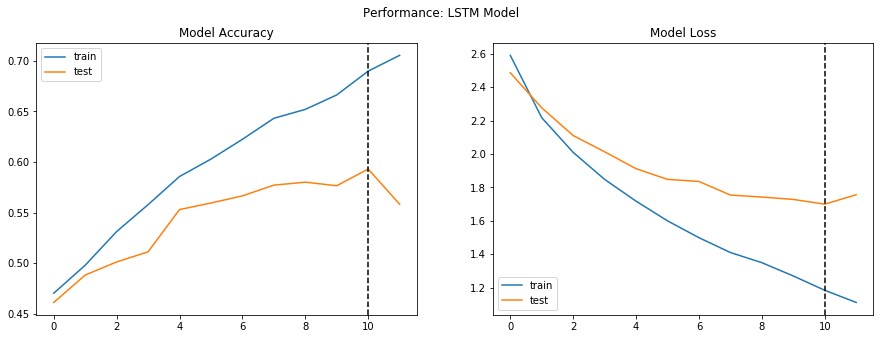

In [124]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance: LSTM Model")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

###### GRU

In [0]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(GRU(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(74, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [126]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          637150    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         137472    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 74)                19018     
Total params: 793,640
Trainable params: 793,640
Non-trainable params: 0
_________________________________________________________________


###### Fit your model


In [127]:
from keras.callbacks import EarlyStopping
history = model.fit(X,y,batch_size=100,epochs=50,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 6800 samples, validate on 1700 samples
Epoch 1/50
6800/6800 [==============================] - 55s 8ms/step - loss: 2.5693 - acc: 0.4762 - val_loss: 2.3573 - val_acc: 0.4676
Epoch 2/50
6800/6800 [==============================] - 53s 8ms/step - loss: 2.1007 - acc: 0.5141 - val_loss: 2.1627 - val_acc: 0.4824
Epoch 3/50
6800/6800 [==============================] - 53s 8ms/step - loss: 1.9015 - acc: 0.5560 - val_loss: 2.0424 - val_acc: 0.5124
Epoch 4/50
6800/6800 [==============================] - 54s 8ms/step - loss: 1.7506 - acc: 0.5832 - val_loss: 1.9270 - val_acc: 0.5512
Epoch 5/50
6800/6800 [==============================] - 57s 8ms/step - loss: 1.6320 - acc: 0.5984 - val_loss: 1.8494 - val_acc: 0.5635
Epoch 6/50
6800/6800 [==============================] - 55s 8ms/step - loss: 1.5165 - acc: 0.6181 - val_loss: 1.7951 - val_acc: 0.5576
Epoch 7/50
6800/6800 [==============================] - 53s 8ms/step - loss: 1.4182 - acc: 0.6350 - val_loss: 1.7519 - val_acc: 0.5688
Epoch 8

###### Plot Graph

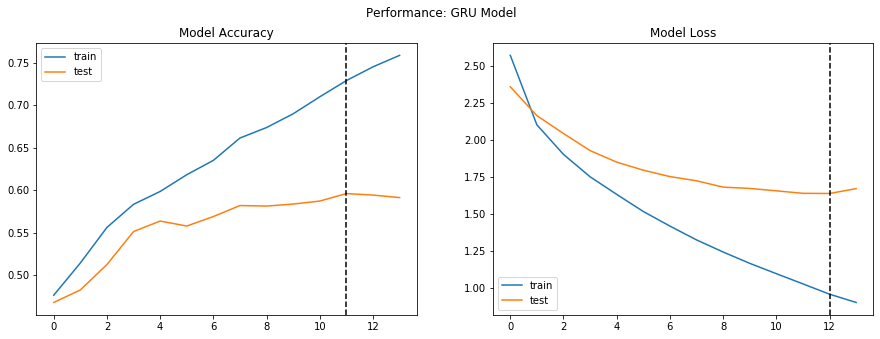

In [128]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance: GRU Model")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

# Summary/Conclusion:

Currently, we have used Classical Machine Learning Model such as Naive Bayes, SVM, GridSearchCV on SVM model, LSTM and GRU models for said text classification.  
As can be seen, the accuracy along with precision and recall for different classes is very low. <br>
The reason for this low accuracy is mentioned below:<br>

         Highly Imbalanced Dataset
         Proper Hyperparameter tuning may be required
         Proper Model selection may be required


We may try below steps to fine tune our model during our next Milestone.
      
      1. Fine tuning existing model with hyper parameters.
      2. Handling imbalance of classes if accuracy with step 1 is not achieved.
      3. Using a different approach altogether. Since the base of the problem talks about L1/L2/L3 groups, our first approach would be to divide the tickets to a larger group of L1/L2/L3 and then break it down into individual groups as given in the dataset.